In [296]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
import scipy.ndimage as ndi

# Funções

## Curvatura do contorno

In [418]:
def curvature(cont):
    y = cont[:,0]
    x = cont[:,1]
    
    size = len(x)
    
    x, y = x.astype(float), y.astype(float)
    #x = ndi.gaussian_filter1d(x, sigma=gauss_sigma, mode='wrap')
    #y = ndi.gaussian_filter1d(y, sigma=gauss_sigma, mode='wrap')
    
    xd = derivative(x)
    yd = derivative(y)
    xdd = derivative(xd)
    ydd = derivative(yd)
    
    k = np.zeros(size)
    
    for i in range(size):
        k[i] = ((xd[i]*ydd[i]) - (xdd[i]*yd[i])) / (((xd[i]**2) + (yd[i]**2))**(3/2))
        
    return np.array(k)
        
def derivative(signal):

    fil_der = np.array([1, -1])
    signal_padded = np.pad(signal, (1,1), mode='wrap')

    df = convolve(signal_padded, fil_der, mode='same')

    return df[1:-1]

## Suavização do contorno

In [369]:
def smoothen(cont, gauss_sigma):
  x = cont[:,0]
  y = cont[:,1]

  x, y = x.astype(float), y.astype(float)
  x = ndi.gaussian_filter1d(x, sigma=gauss_sigma, mode='wrap')
  y = ndi.gaussian_filter1d(y, sigma=gauss_sigma, mode='wrap')

  smoothed_cont = []

  for i in range(len(x)):
    smoothed_cont.append(np.array([x[i], y[i]]))

  return np.array(smoothed_cont)

## Extração do contorno paramétrico
Código retirado do notebook fornecido em aula

In [501]:
def image_contour(img):
    '''Obtém o contorno paramétrico de um objeto contido
       no array img.'''
    
    # Mapeamento utilizado para encontrar o vizinho inicial a ser
    # buscado na próxima iteração dado o vizinho do ponto atual
    # Por exemplo, se o ponto atual for (12, 15) e o próximo ponto
    # de borda for (12, 16), isso significa que o vizinho de índice
    # 2 será o próximo ponto de borda. Nesse novo ponto, precisamos
    # buscar a partir do vizinho de índice 1, pois o vizinho de
    # índice 0 foi o último ponto a ser verificado antes de encontrarmos
    # o ponto atual
    neighbor_map = [7, 7, 1, 1, 3, 3, 5, 5]
    
    # Adiciona 0 ao redor da imagem para evitar pontos 
    # do objeto tocando a borda
    img_pad = np.pad(img, 1, mode='constant')
    
    num_rows, num_cols = img_pad.shape
    k = 0
    row = 0
    col = 0
    # Busca do primeiro ponto do objeto
    while img_pad[row, col]==0:
        k += 1
        row = k//num_cols
        col = k - row*num_cols
    
    curr_point = (row, col)    # Ponto atual

    contour = [curr_point]     # Pontos do contorno
    starting_index = 2         # Índice do vizinho inicial a ser verificado
    while True:
        next_point, last_index = get_next_point(img_pad, curr_point, 
                                                    starting_index)

        # Novo índice do vizinho inicial baseado no último
        # índice buscado
        starting_index = neighbor_map[last_index]
        
        # Critério de parada. Se o ponto adicionado na iteração anterior (contour[-1])
        # for o mesmo que o primeiro ponto (contour[0]) e o ponto atual for o mesmo
        # que o segundo ponto adicionado, o algoritmo termina. Só podemos fazer essa
        # verificação se o contorno possuir ao menos 2 pontos. Ou seja, nosso algoritmo
        # não está tratando o caso de um objeto com apenas 1 pixel
        if len(contour)>1:
            if next_point==contour[1] and contour[-1]==contour[0]:
                break
                
        contour.append(next_point)
        curr_point = next_point
        
    # Subtrai 1 de cada ponto pois o contorno foi encontrado para a
    # imagem preenchida com 0 na borda
    for point_index, point in enumerate(contour):
        contour[point_index] = (point[0]-1, point[1]-1)
    
    
    return np.array(contour)

def get_next_point(img, curr_point, starting_index):
    '''Encontra o próximo ponto de borda dado um ponto
       corrente curr_point e o índice do primeiro vizinho
       a ser verificado (starting_index)'''
     
    # Lista dos pontos vizinhos dado o índice do vizinho
    nei_list = [(-1,0), (-1,1), (0,1), (1,1), 
                (1,0), (1,-1),(0,-1), (-1,-1)]
    
    curr_index = starting_index
    nei_value = 0
    while nei_value==0:
        nei_shift = nei_list[curr_index]
        nei_row = curr_point[0] + nei_shift[0]
        nei_col = curr_point[1] + nei_shift[1]
        nei_value = img[nei_row, nei_col]
        if nei_value==1:
            return (nei_row, nei_col), curr_index
        else:
            curr_index = (curr_index+1)%8

## Normalização das imagens

In [312]:
def pre_processing(img):
     
    # normalizar valores
    img_norm = img - np.min(img)
    img_norm = img_norm/1

    # rgb to grayscale
    img_gray = 0.299*img_norm[:,:,0] + 0.587*img_norm[:,:,1] + 0.114*img_norm[:,:,2]

    # binarização
    img = img_gray>0.5

    return img

## Heurística para mínimo e máximo local

In [641]:
def local_and_global_min_max(curv, cont):
  
  mins = []
  min_points = []
  maxs = []
  max_points = []

  # padding para poder verificar se os extremos são min/max locais
  curv_pad = np.pad(curv, (1, 1), mode='wrap')
  curv_pad = curv_pad.astype(float)

  for index in range(len(curv)):

    # se o valor atual é menor que o anterior e que o proximo
    if curv_pad[index+1] < curv_pad[index] and curv_pad[index+1] < curv_pad[index+2]:
      mins.append([curv_pad[index+1], index])
      min_points.append(cont[index])
      
    # se o valor atual é maior que o anterior e que o proximo
    if curv_pad[index+1] > curv_pad[index] and curv_pad[index+1] > curv_pad[index+2]:
      maxs.append([curv_pad[index+1], index])
      max_points.append(cont[index])
        

  min_global_curv = []
  min_global_cont = []
  max_global_curv = []
  max_global_cont = []

  max_value = max(curv_pad)
  min_value = min(curv_pad)

  # Calculo dos minimos e maximos globais 
  for i in range(len(mins)):
    if mins[i][0] == min_value:
      min_global_curv.append([min_value, mins[i][1]])
      min_global_cont.append(min_points[i])

  for i in range(len(maxs)):
    if maxs[i][0] == max_value:
      max_global_curv.append([max_value, maxs[i][1]])
      max_global_cont.append(max_points[i])


  
  mins = np.array(mins)
  maxs = np.array(maxs)
  min_points = np.array(min_points)
  max_points = np.array(max_points)
  min_global_curv = np.array(min_global_curv)
  min_global_cont = np.array(min_global_cont)
  max_global_curv = np.array(max_global_curv)
  max_global_cont = np.array(max_global_cont)

  return [mins, min_points], [maxs, max_points], [min_global_curv, min_global_cont], [max_global_curv, max_global_cont]

## Plotar máximos e mínimos

In [674]:
def plot_max_min(img, img_curv, img_cont):
  # Mínimos e máximos da img
  min_local, max_local, min_global, max_global = local_and_global_min_max(img_curv, img_cont)
  mins_curv, mins_cont = min_local
  min_g_curv, min_g_cont = min_global
  maxs_curv, maxs_cont = max_local
  max_g_curv, max_g_cont = max_global

  # Mínimos
  fig, ax = plt.subplots(1, 2, figsize=[12, 6])
  fig.suptitle(f'Mínimos da curvatura do obj na imagem')
  ax[0].set_title('Contorno suavizado')
  ax[0].plot(img_cont[:,1], img.shape[0]-img_cont[:,0])
  if mins_curv.any():
    ax[0].scatter(mins_cont[:, 1], img.shape[0]-mins_cont[:, 0], c=range(len(mins_cont)), cmap='hsv', s=50)
    ax[0].scatter(min_g_cont[:, 1], img.shape[0]-min_g_cont[:, 0], c='black', s=100)

  ax[1].set_title('Curvatura')
  ax[1].plot(img_curv)
  if mins_curv.any():
    ax[1].scatter(mins_curv[:, 1], mins_curv[:,0], c=range(len(mins_curv)), cmap='hsv', s=50)
    _ = ax[1].scatter(min_g_curv[:, 1], min_g_curv[:, 0], c='black', s=100)

  # Máximos
  fig, ax = plt.subplots(1, 2, figsize=[12, 6])
  fig.suptitle(f'Máximos da curvatura do obj na imagem')

  ax[0].set_title('Contorno suavizado')
  ax[0].plot(img_cont[:,1], img.shape[0]-img_cont[:,0])
  if maxs_curv.any():
    ax[0].scatter(maxs_cont[:, 1], img.shape[0]-maxs_cont[:, 0], c=range(len(maxs_cont)), cmap='hsv', s=50)
    ax[0].scatter(max_g_cont[:, 1], img.shape[0]-max_g_cont[:, 0], c='black', s=100)

  ax[1].set_title('Curvatura')
  ax[1].plot(img_curv)
  if maxs_curv.any():
    ax[1].scatter(maxs_curv[:, 1], maxs_curv[:,0], c=range(len(maxs_curv)), cmap='hsv', s=50)
    _ = ax[1].scatter(max_g_curv[:, 1], max_g_curv[:, 0], c='black', s=100)

# Testes

### Carregamento e binarização de imagens

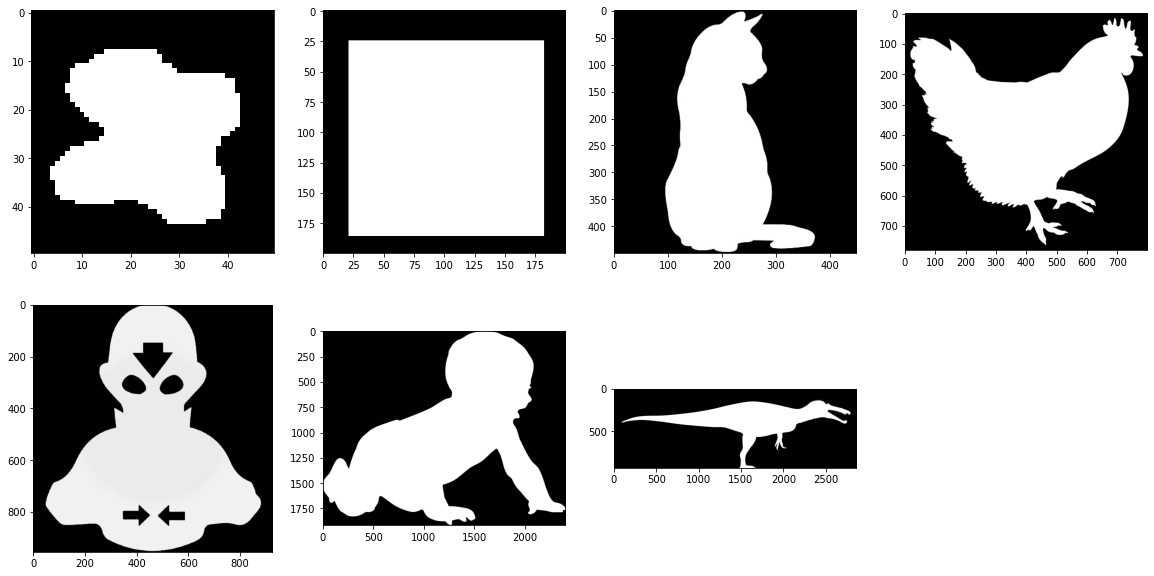

In [685]:
# Carregando e plotando imagens

plt.figure(figsize=[20,10])
blob = plt.imread('imgs/blob.tiff')
plt.subplot(2, 4, 1)
plt.imshow(blob, 'gray')

square = plt.imread('imgs/square.png')
plt.subplot(2, 4, 2)
plt.imshow(square)

cat = plt.imread('imgs/cat.png')
plt.subplot(2, 4, 3)
plt.imshow(cat)

chicken = plt.imread('imgs/chicken.png')
plt.subplot(2, 4, 4)
plt.imshow(chicken)

aang = plt.imread('imgs/aang.png')
plt.subplot(2, 4, 5)
plt.imshow(aang)

baby = plt.imread('imgs/baby.png')
plt.subplot(2, 4, 6)
plt.imshow(baby)

cristatusaurus = plt.imread('imgs/cristatusaurus.png')
plt.subplot(2, 4, 7)
plt.imshow(cristatusaurus)


# Binarizando imagens

blob = blob>0
square = pre_processing(square)
cat = pre_processing(cat)
chicken = pre_processing(chicken)
aang = pre_processing(aang)
baby = pre_processing(baby)
cristatusaurus = pre_processing(cristatusaurus)

### Geração dos contornos

In [713]:
# Gerando contornos e suavizando os mesmos 

cont_blob = image_contour(blob)
cont_blob = smoothen(cont_blob, 3)

cont_square = image_contour(square)
cont_square = smoothen(cont_square, 10)

cont_cat = image_contour(cat)
cont_cat = smoothen(cont_cat, 20)

cont_chicken = image_contour(chicken)
cont_chicken = smoothen(count_chicken, 40)

cont_aang = image_contour(aang)
cont_aang = smoothen(cont_aang, 50)

cont_baby = image_contour(baby)
cont_baby = smoothen(cont_baby, 120)

cont_cristatusaurus = image_contour(cristatusaurus)
cont_cristatusaurus = smoothen(cont_cristatusaurus, 120)

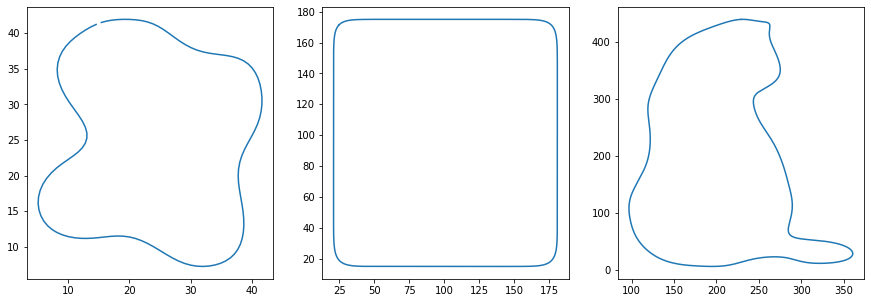

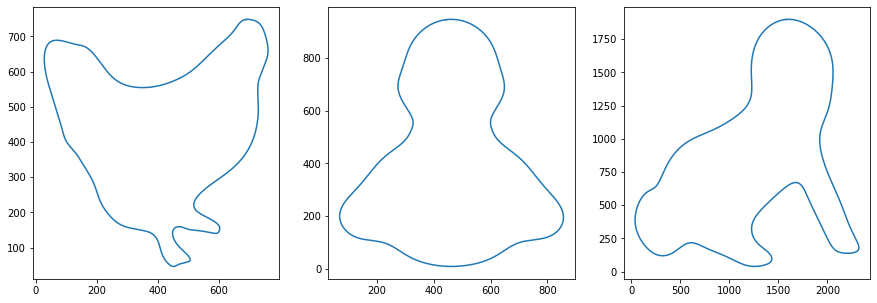

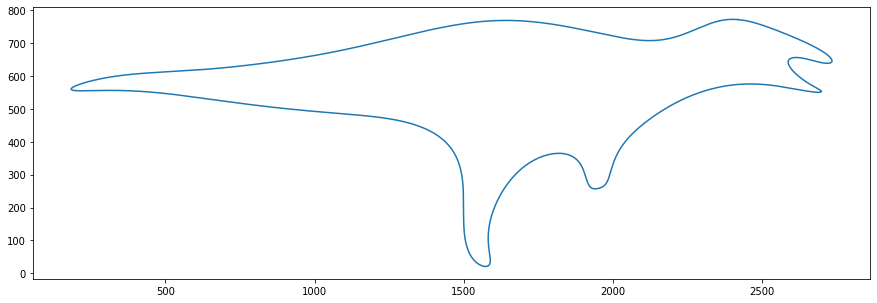

In [714]:
# Plotando contornos

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
plt.plot(cont_blob[:,1], blob.shape[0]-cont_blob[:,0])

plt.subplot(1, 3, 2)
plt.plot(cont_square[:,1], square.shape[0]-cont_square[:,0])

plt.subplot(1, 3, 3)
plt.plot(cont_cat[:,1], cat.shape[0]-cont_cat[:,0])

plt.figure(figsize=[15, 5])
plt.subplot(1, 3, 1)
plt.plot(cont_chicken[:,1], chicken.shape[0]-cont_chicken[:,0])

plt.subplot(1, 3, 2)
plt.plot(cont_aang[:,1], aang.shape[0]-cont_aang[:,0])

plt.subplot(1, 3, 3)
plt.plot(cont_baby[:,1], baby.shape[0]-cont_baby[:,0])

plt.figure(figsize=[15,5])
plt.plot(cont_cristatusaurus[:,1], cristatusaurus.shape[0]-cont_cristatusaurus[:,0])

### Cálculo das curvaturas
(lembrando que não sabemos se nossa curvatura está certa kkk)

In [715]:
# Calculando as curvaturas

curv_blob = curvature(cont_blob_sm)

curv_square = curvature(cont_square_sm)

curv_cat = curvature(cont_cat_sm)

curv_chicken = curvature(cont_chicken_sm)

curv_aang = curvature(cont_aang_sm)

curv_baby = curvature(cont_baby_sm)

curv_cristatusaurus = curvature(cont_cristatusaurus_sm)

O ponto verde representa o início da curvatura.
O ponto vermelho representa o final da curvatura.


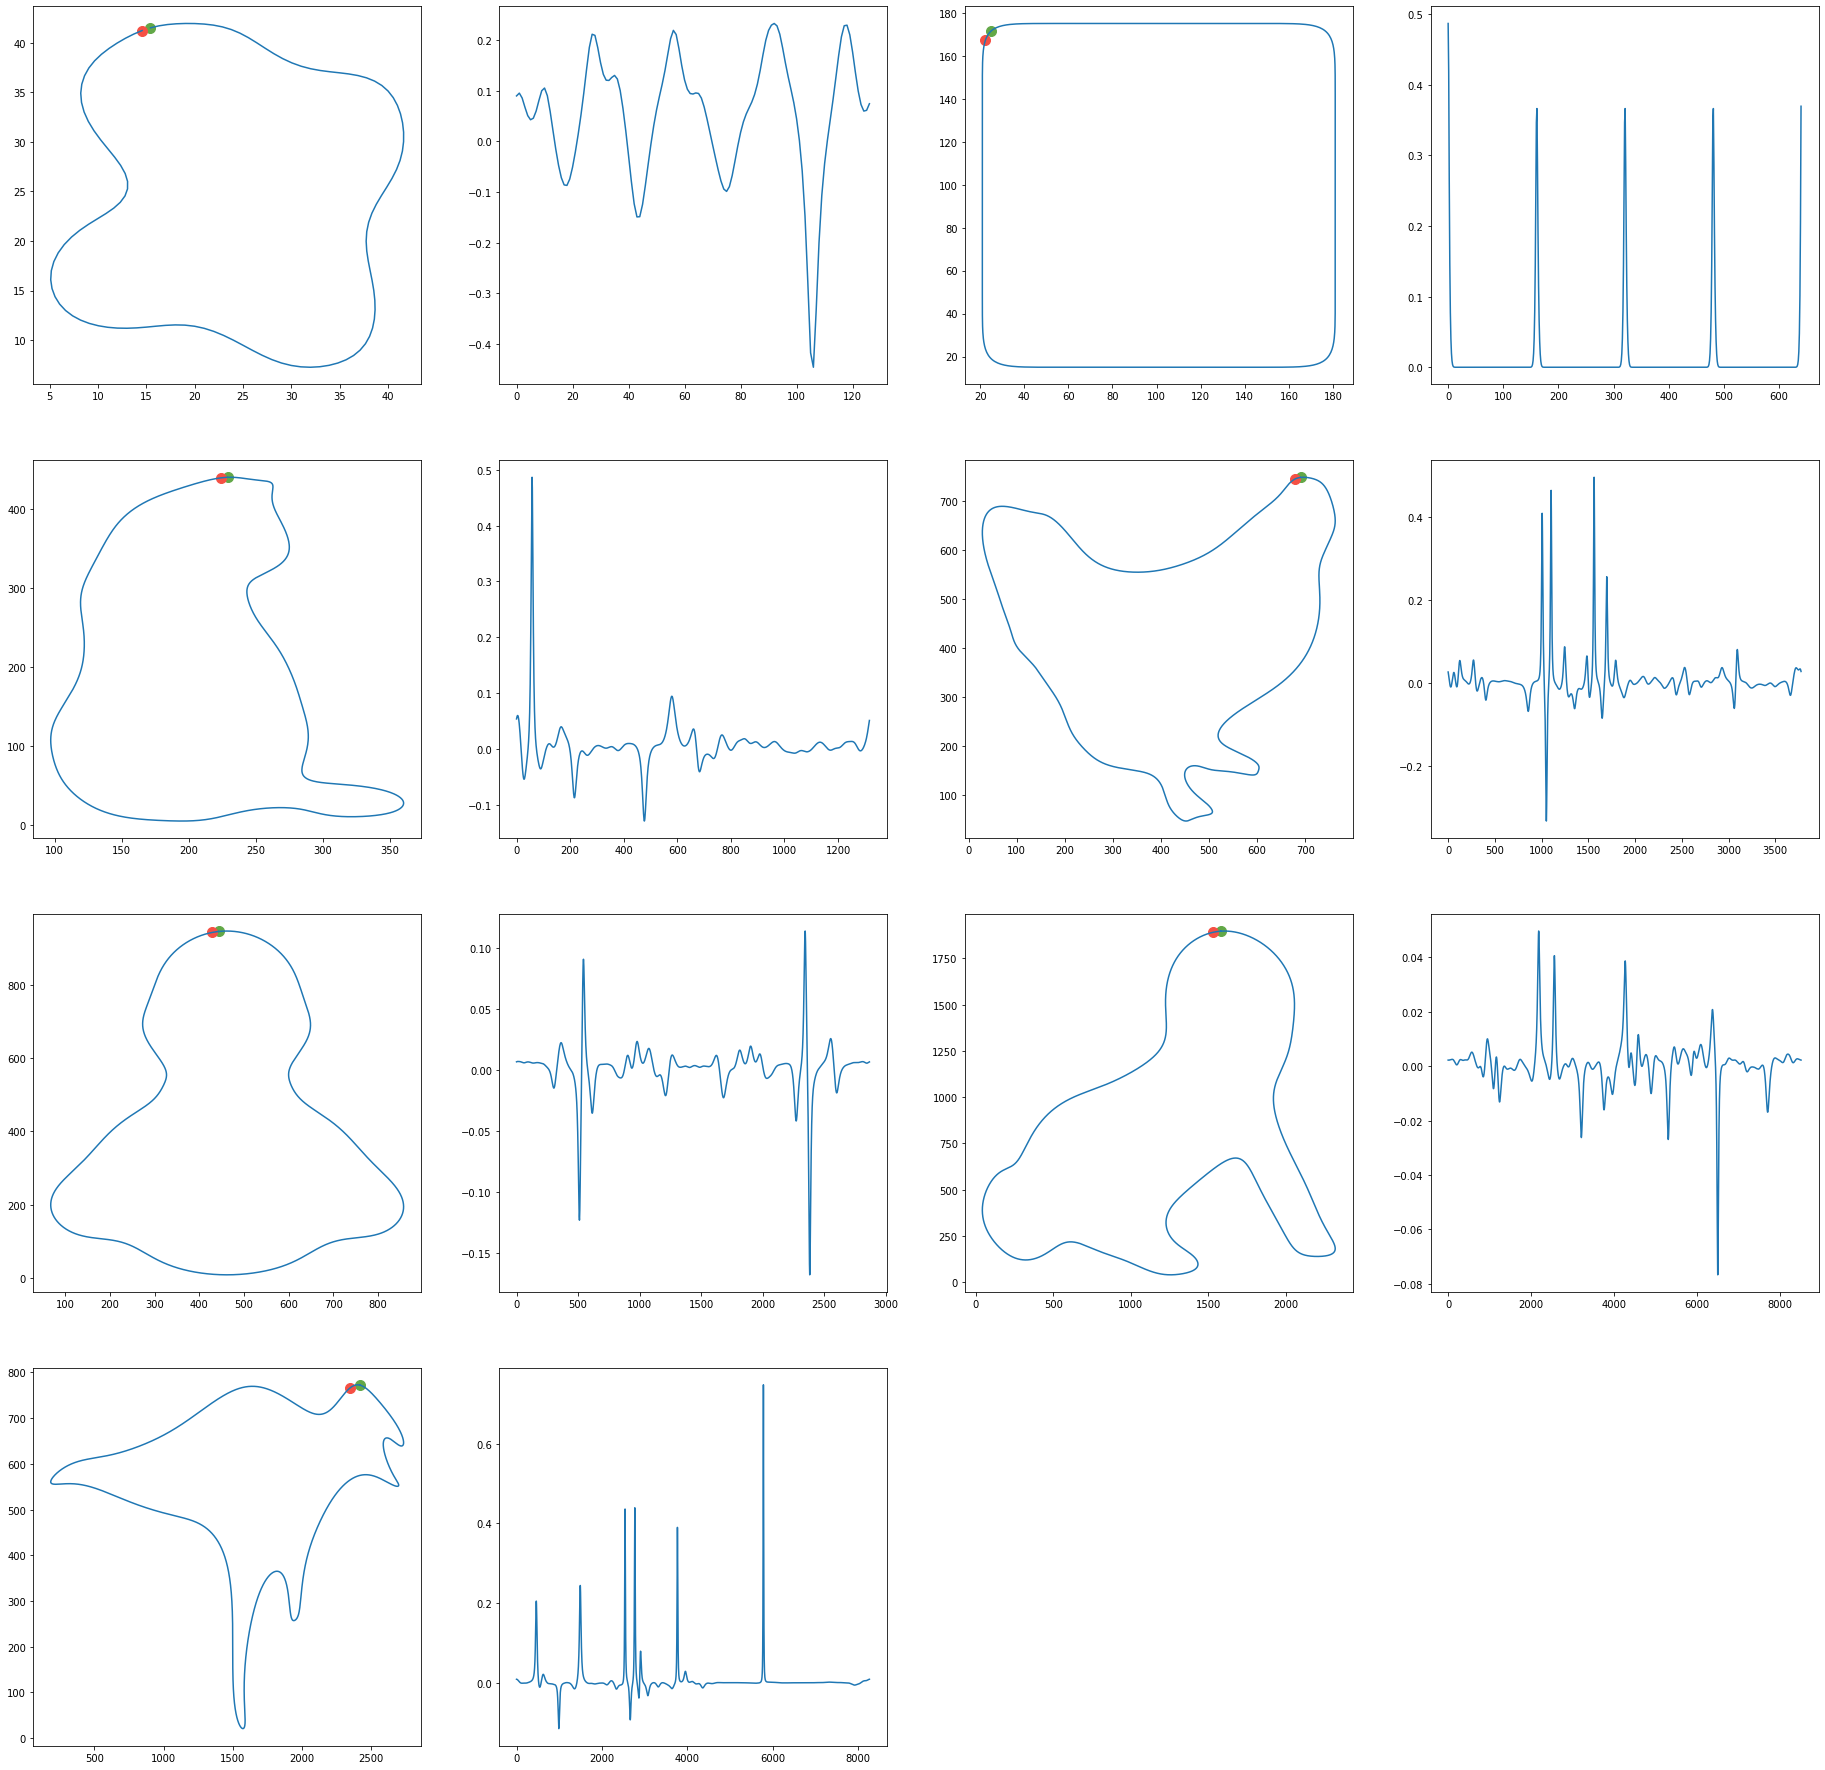

In [716]:
# Plotando os contornos suavizados com sua respectiva curvatura
# E com sinais indicando o início e fim dos pontos da curvatura no contorno
plt.figure(figsize=[32, 32])
print('O ponto verde representa o início da curvatura.')
print('O ponto vermelho representa o final da curvatura.')

plt.subplot(4, 4, 1)
plt.plot(cont_blob[:,1], blob.shape[0]-cont_blob[:,0])
plt.scatter(cont_blob[0][1], blob.shape[0]-cont_blob[0][0], c='#62A847', s=100)
plt.scatter(cont_blob[-1][1], blob.shape[0]-cont_blob[-1][0], c='#F55044', s=100)
plt.subplot(4, 4, 2)
plt.plot(curv_blob)

plt.subplot(4, 4, 3)
plt.plot(cont_square[:,1], square.shape[0]-cont_square[:,0])
plt.scatter(cont_square[0][1], square.shape[0]-cont_square[0][0], c='#62A847', s=100)
plt.scatter(cont_square[-7][1], square.shape[0]-cont_square[-7][0], c='#F55044', s=100)
plt.subplot(4, 4, 4)
plt.plot(curv_smoothed_square)

plt.subplot(4, 4, 5)
plt.plot(cont_cat[:,1], cat.shape[0]-cont_cat[:,0])
plt.scatter(cont_cat[0][1], cat.shape[0]-cont_cat[0][0], c='#62A847', s=100)
plt.scatter(cont_cat[-7][1], cat.shape[0]-cont_cat[-7][0], c='#F55044', s=100)
plt.subplot(4, 4, 6)
plt.plot(curv_cat)

plt.subplot(4, 4, 7)
plt.plot(cont_chicken[:,1], chicken.shape[0]-cont_chicken[:,0])
plt.scatter(cont_chicken[0][1], chicken.shape[0]-cont_chicken[0][0], c='#62A847', s=100)
plt.scatter(cont_chicken[-30][1], chicken.shape[0]-cont_chicken[-30][0], c='#F55044', s=100)
plt.subplot(4, 4, 8)
plt.plot(curv_chicken)

plt.subplot(4, 4, 9)
plt.plot(cont_aang[:,1], aang.shape[0]-cont_aang[:,0])
plt.scatter(cont_aang[0][1], aang.shape[0]-cont_aang[0][0], c='#62A847', s=100)
plt.scatter(cont_aang[-15][1], aang.shape[0]-cont_aang[-15][0], c='#F55044', s=100)
plt.subplot(4, 4, 10)
plt.plot(curv_aang)

plt.subplot(4, 4, 11)
plt.plot(cont_baby[:,1], baby.shape[0]-cont_baby[:,0])
plt.scatter(cont_baby[0][1], baby.shape[0]-cont_baby[0][0], c='#62A847', s=100)
plt.scatter(cont_baby[-50][1], baby.shape[0]-cont_baby[-50][0], c='#F55044', s=100)
plt.subplot(4, 4, 12)
plt.plot(curv_baby)

plt.subplot(4, 4, 13)
plt.plot(cont_cristatusaurus[:,1], cristatusaurus.shape[0]-cont_cristatusaurus[:,0])
plt.scatter(cont_cristatusaurus[0][1], cristatusaurus.shape[0]-cont_cristatusaurus[0][0], c='#62A847', s=100)
plt.scatter(cont_cristatusaurus[-100][1], cristatusaurus.shape[0]-cont_cristatusaurus[-100][0], c='#F55044', s=100)
plt.subplot(4, 4, 14)
_ =plt.plot(curv_cristatusaurus)

# Análise das curvaturas
(basicamente vários plots)

## Blob

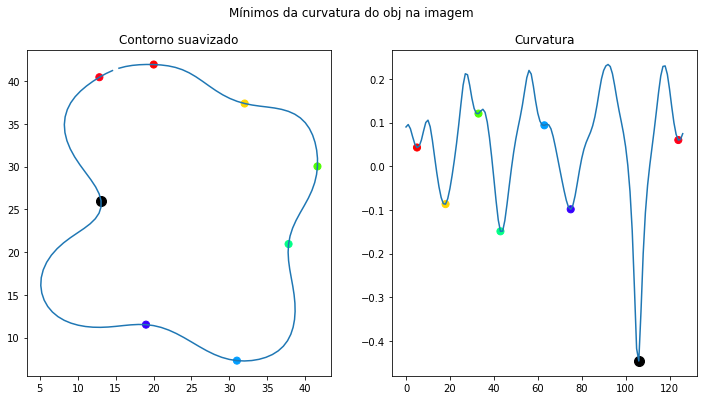

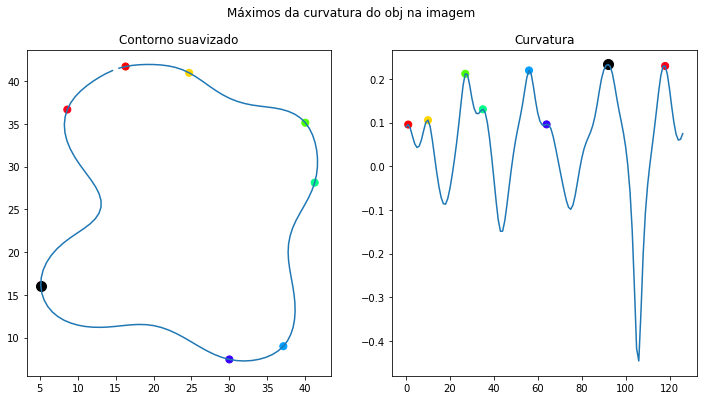

In [717]:
plot_max_min(blob, curv_blob, cont_blob)

## Square

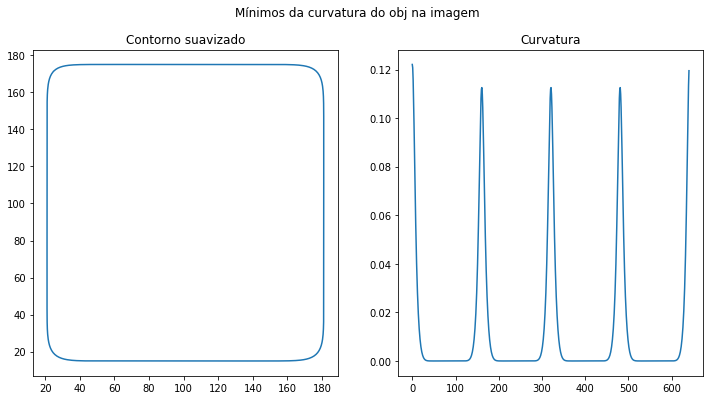

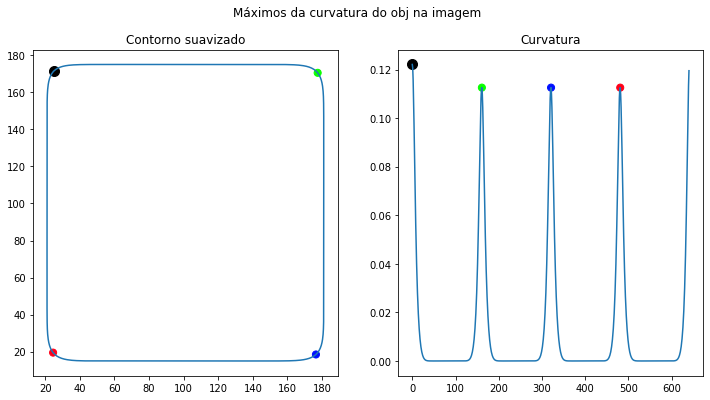

In [718]:
plot_max_min(square, curv_square, cont_square)

## Cat

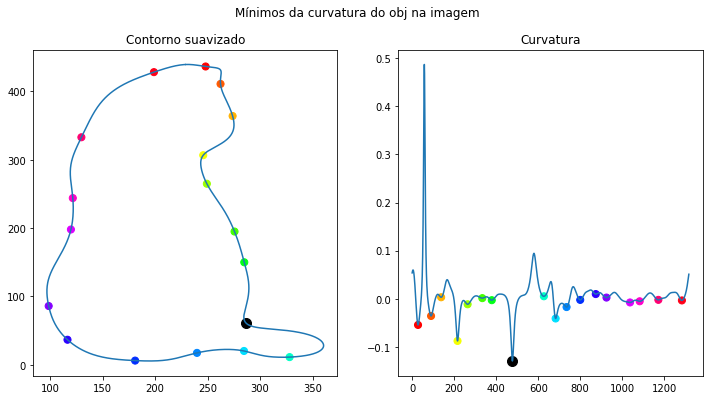

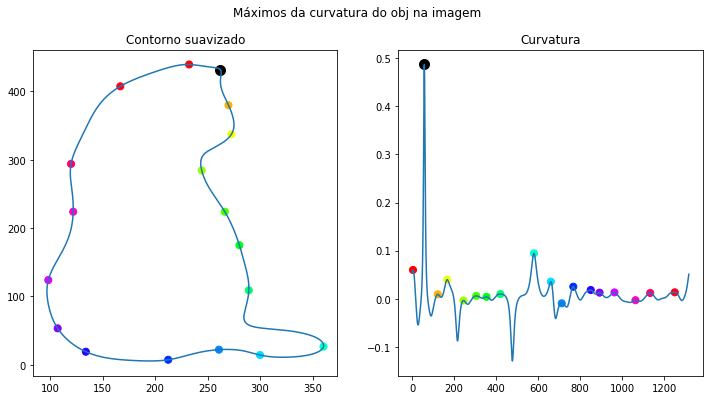

In [719]:
plot_max_min(cat, curv_cat, cont_cat)

## Chicken

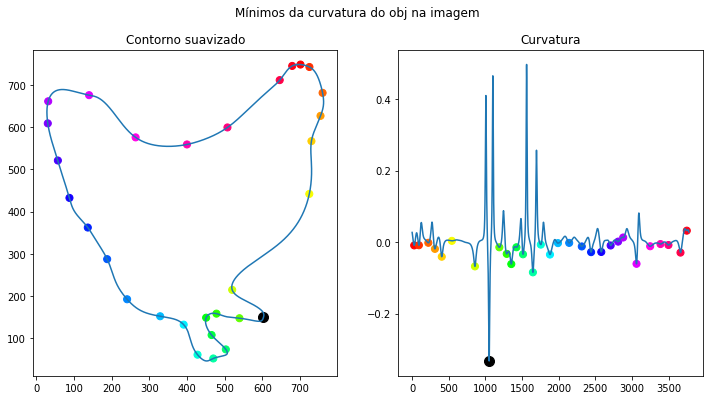

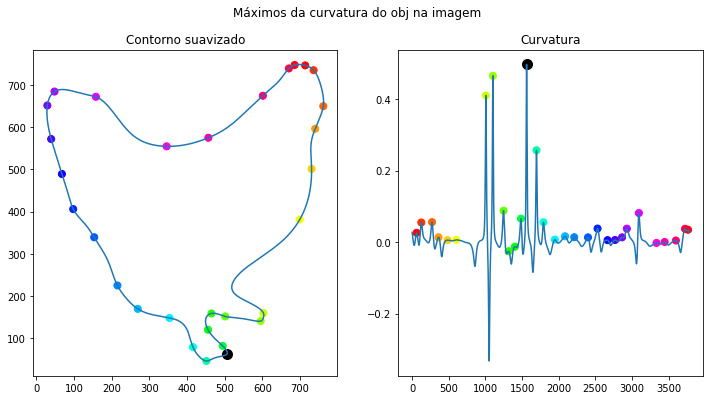

In [720]:
plot_max_min(chicken, curv_chicken, cont_chicken)

## Aang

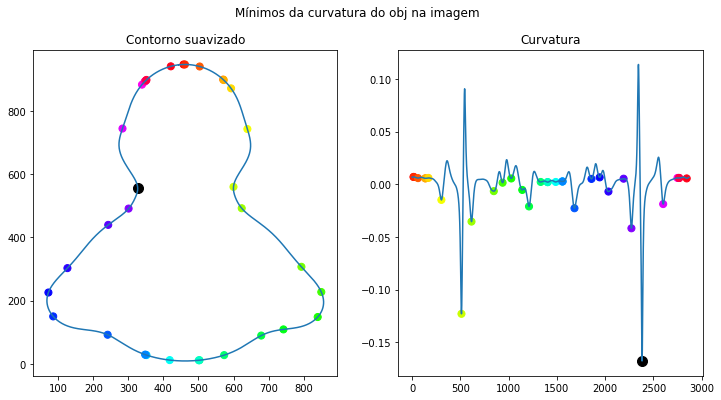

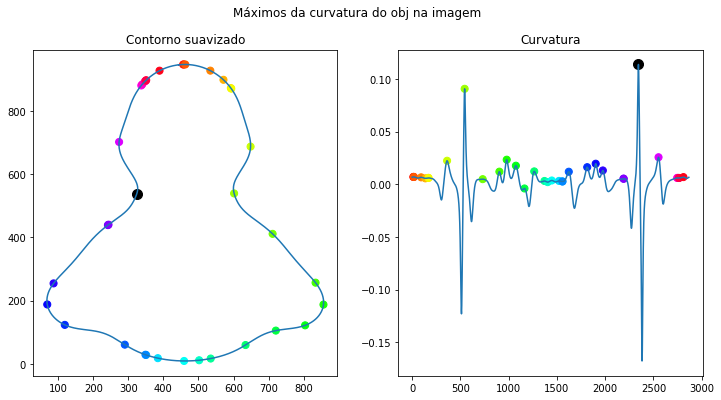

In [721]:
plot_max_min(aang, curv_aang, cont_aang)

## Baby

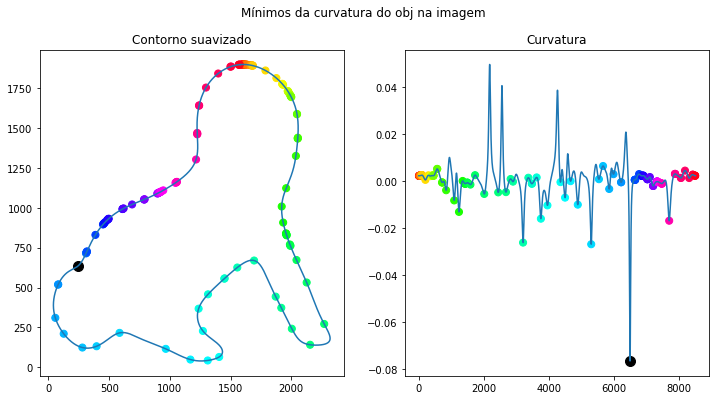

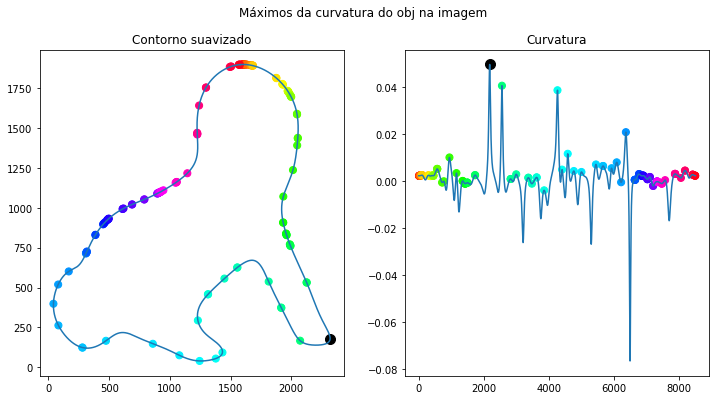

In [722]:
plot_max_min(baby, curv_baby, cont_baby)

## Cristatusaurus

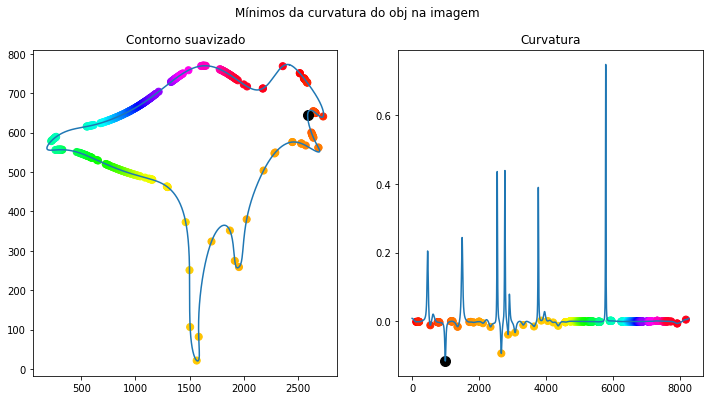

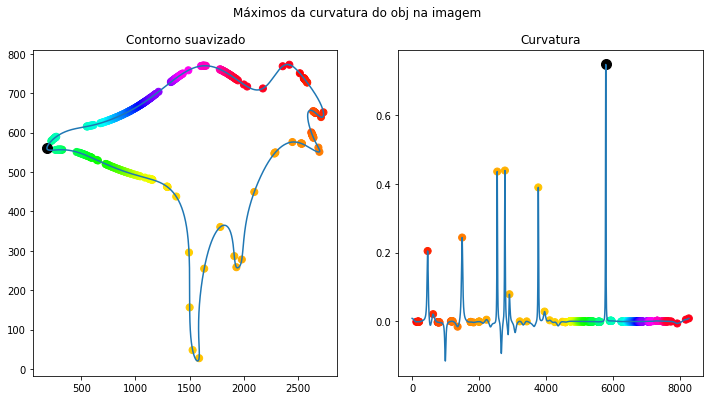

In [723]:
plot_max_min(cristatusaurus, curv_cristatusaurus, cont_cristatusaurus)